## Getting SHAP Values

**Author**: Mark Romanowsky

#### Scope
The scope of this notebook is to provide you instructions on how to get SHAP values using the Python API

#### Requirements
* Python version 3.7
* DataRobot python API client version 2.21 or later
* Your DataRobot API token
* IDs for your DataRobot project with a trained, SHAP-enabled model
* pandas and shap for the sections that specifically use them

#### Import libraries & Connect to DataRobot

In [1]:
import datarobot as dr
import pandas as pd
import datetime

dr.Client('YOUR_API_TOKEN', 
          endpoint='YOUR_ENDPOINT')

#### Connect to a project and model that was created earlier.

In [3]:
project_id = 'YOUR_PROJECT_ID'
model_id = 'YOUR_MODEL_ID'
project = dr.Project.get(project_id)
model = dr.Model.get(project=project_id, model_id=model_id)

#### Verify that the model supports SHAP

In [4]:
model_capabilities = model.get_supported_capabilities()
print(model_capabilities.get('supportsShap'))

True


#### Retrieve the SHAP feature impact (already computed in the UI)

In [5]:
# get the model's SHAP feature impact
shap_feature_impact = dr.ShapImpact.get(project_id, model_id)

In [6]:
# inspect the top 5 features
shap_feature_impact.shap_impacts[:5]

[{'feature_name': 'squareMeters',
  'impact_normalized': 1.0,
  'impact_unnormalized': 99.9732448247711},
 {'feature_name': 'tradeTime (Year)',
  'impact_normalized': 0.9519971828991194,
  'impact_unnormalized': 95.17424743846605},
 {'feature_name': 'communityAverage',
  'impact_normalized': 0.9041298477553755,
  'impact_unnormalized': 90.38879462303117},
 {'feature_name': 'tradeTime (Month)',
  'impact_normalized': 0.17220384076590783,
  'impact_unnormalized': 17.215776732656003},
 {'feature_name': 'Lat',
  'impact_normalized': 0.102703101759732,
  'impact_unnormalized': 10.267562336489068}]

### Get the shap explanations for the training data, including more top explanations than we saw in the UI

In [7]:
# get the shap explanations for the training data, with top 10 explanations in each row
# try/except needed because training predictions can be requested only once for each set of params

try:
    training_preds_job = model.request_training_predictions('validation', explanation_algorithm='shap', max_explanations=10)
    training_preds = training_preds_job.get_result_when_complete()
    training_shap_df = training_preds.get_all_as_dataframe()
    
except:  
    training_preds = dr.TrainingPredictions.list(project_id=project_id)[0]
    training_shap_df = training_preds.get_all_as_dataframe()

Now there are 10 triples of (feature_name, feature_value, explanation_strength). At the end of the row, we see 'remaining_shap_total' for the features that weren't listed in the top 10 of that row.

In [9]:
training_shap_df.head()

,row_id,partition_id,prediction,Explanation_1_feature_name,Explanation_1_feature_value,Explanation_1_strength,Explanation_2_feature_name,Explanation_2_feature_value,Explanation_2_strength,Explanation_3_feature_name,...,Explanation_8_feature_value,Explanation_8_strength,Explanation_9_feature_name,Explanation_9_feature_value,Explanation_9_strength,Explanation_10_feature_name,Explanation_10_feature_value,Explanation_10_strength,shap_remaining_total,shap_base_value
0,0,0.0,522.978191,squareMeters,131.0,162.435520,tradeTime (Year),2016,79.440903,communityAverage,...,3,-9.109102,buildingType,1.0,-7.971550,Lng,116.475489,-7.015957,16.058249,349.110666
1,12,0.0,907.956707,squareMeters,238.0,532.941740,communityAverage,46867.0,-133.376656,tradeTime (Year),...,底 3,15.394878,livingRoom,4.0,15.130608,Lng,116.47617,-13.631813,-11.939708,349.110666
2,13,0.0,867.711794,communityAverage,123002.0,312.203053,tradeTime (Year),2016,105.879961,squareMeters,...,0.0,-10.463616,Lng,116.399018,6.596329,Lat,39.978141,5.689124,0.368536,349.110666
3,20,0.0,1975.881373,squareMeters,308.41,907.088599,communityAverage,101192.0,314.717514,tradeTime (Year),...,116.507351,-39.354256,constructionTime,2011.0,36.305031,renovationCondition,4,35.015767,33.159284,349.110666
4,32,0.0,250.993201,squareMeters,56.92,-95.569891,tradeTime (Year),2016,53.111393,communityAverage,...,116.376709,6.925793,followers,57,-6.658429,elevator,1.0,5.390017,1.355614,349.110666


### Upload a "new" dataset (in this case, just the first 100 rows of the original dataframe)

In [10]:
original_data = pd.read_csv('./Beijing_housing.csv', encoding = 'gb2312')

/Users/mark.romanowsky/.virtualenvs/jupyter/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
original_data.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,pricePerSquareMeter,...,buildingType,constructionTime,renovationCondition,buildingStructure,stairsRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [12]:
first_rows = original_data.iloc[:100, :]

In [14]:
dataset_to_predict = project.upload_dataset(first_rows)

#### Get predictions plus shap explanations for this dataset, again including 10 top explanations in each row

In [15]:
new_preds_job = model.request_predictions(dataset_to_predict.id, explanation_algorithm='shap', max_explanations=10)
new_preds = new_preds_job.get_result_when_complete()

In [16]:
new_preds

,prediction,row_id,Explanation_1_feature_name,Explanation_1_feature_value,Explanation_1_strength,Explanation_2_feature_name,Explanation_2_feature_value,Explanation_2_strength,Explanation_3_feature_name,Explanation_3_feature_value,...,Explanation_8_feature_value,Explanation_8_strength,Explanation_9_feature_name,Explanation_9_feature_value,Explanation_9_strength,Explanation_10_feature_name,Explanation_10_feature_value,Explanation_10_strength,shap_remaining_total,shap_base_value
0,522.978191,0,squareMeters,131.0,162.435520,tradeTime (Year),2016,79.440903,communityAverage,56021.0,...,3,-9.109102,buildingType,1.0,-7.971550,Lng,116.475489,-7.015957,16.058249,349.110666
1,667.424418,1,squareMeters,132.38,193.094763,tradeTime (Year),2016,86.431048,communityAverage,71539.0,...,116.453917,6.981312,floor,高 22,6.405911,subway,0.0,-5.886585,6.539673,349.110666
2,958.501053,2,squareMeters,198.0,396.524474,tradeTime (Year),2016,124.089958,communityAverage,48160.0,...,7,15.324019,fiveYearsProperty,0.0,14.201234,followers,48,12.246842,66.907754,349.110666
3,380.988457,3,squareMeters,134.0,159.136457,communityAverage,51238.0,-81.908491,tradeTime (Year),2016,...,6,-20.995452,followers,138,-18.865410,renovationCondition,1,-15.818568,-30.953290,349.110666
4,372.316686,4,tradeTime (Year),2016,73.935328,constructionTime,1960.0,-29.370534,followers,286,...,8,7.576814,elevator,0.0,-7.070471,Lng,116.428392,7.017891,6.112388,349.110666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,890.543641,95,squareMeters,160.0,292.835686,communityAverage,93339.0,186.849039,tradeTime (Year),2016,...,1999.0,-24.269557,buildingStructure,2,-21.921570,bathRoom,2.0,19.516654,-14.406679,349.110666
96,289.595419,96,communityAverage,40470.0,-111.596406,tradeTime (Year),2016,60.079688,stairsRatio,0.19,...,7,4.579103,renovationCondition,1,-4.504694,tradeTime (Month),7,-3.725352,-0.854096,349.110666
97,253.926748,97,communityAverage,39605.0,-132.450604,tradeTime (Year),2016,65.213701,squareMeters,89.0,...,72,-10.594304,constructionTime,1992.0,-10.001298,renovationCondition,1,-8.689475,-4.648615,349.110666
98,1294.961796,98,squareMeters,258.0,586.899247,communityAverage,85111.0,203.580694,tradeTime (Year),2016,...,2,-26.407274,renovationCondition,4,26.286169,Lat,40.039,-23.735625,33.486480,349.110666


#### Get the raw shap matrix for predictions based on this dataset.

In [17]:
shap_matrix_job = dr.ShapMatrix.create(project_id=project_id, model_id=model_id, dataset_id=dataset_to_predict.id)
shap_matrix = shap_matrix_job.get_result_when_complete()
shap_matrix_df = shap_matrix.get_as_dataframe()

In [21]:
shap_matrix_df

,drawingRoom,floor,tradeTime (Day of Week),tradeTime (Month),Lng,Lat,Cid,followers,squareMeters,livingRoom,...,renovationCondition,buildingStructure,stairsRatio,elevator,fiveYearsProperty,subway,district,communityAverage,tradeTime (Day of Month),tradeTime (Year)
0,-1.014097,14.411601,1.045232,5.707454,-7.015957,14.011350,-0.220184,-9.817382,162.435520,-1.057305,...,-9.109102,5.025601,-29.974053,5.543071,-1.192282,2.039456,5.924756,-48.602054,-3.202955,79.440903
1,-0.236275,6.405911,-2.196328,-5.325326,6.981312,-4.863110,-0.035929,-18.845954,193.094763,-0.035489,...,7.548275,4.375683,3.127712,7.100887,-3.541799,-5.886585,5.575626,48.344075,1.606089,86.431048
2,6.957355,1.366663,1.415724,80.035388,-41.243677,1.835698,9.947584,12.246842,396.524474,17.133265,...,-9.228105,9.432254,11.389889,10.848904,14.201234,-0.752299,15.324019,-123.603151,6.055339,124.089958
3,-1.314749,-21.667566,0.769357,32.688943,-6.954922,-26.334947,-21.936964,-18.865410,159.136457,5.097376,...,-15.818568,4.108610,-14.798148,5.578519,-4.870292,-6.564430,-20.995452,-81.908491,7.102556,78.533078
4,1.375524,8.357465,-1.414561,7.576814,7.017891,1.158179,-0.076267,-25.616818,-1.756569,2.814310,...,-17.025543,-8.568134,-1.797138,-7.070471,0.491660,1.641288,7.857634,-0.776097,2.247834,73.935328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.899028,-35.902451,-2.069904,31.532964,16.439466,-30.786358,-0.003276,-13.546806,292.835686,-10.125090,...,-14.491150,-21.921570,7.402076,-16.490661,4.400881,3.079848,26.989804,186.849039,-3.001302,110.995443
96,0.072443,-0.327360,-0.516416,-3.725352,3.576567,4.923115,-0.146154,-2.315969,10.458414,-10.986371,...,-4.504694,2.800058,-13.849067,5.960418,-1.717600,1.774829,4.579103,-111.596406,0.930542,60.079688
97,-0.314611,-12.897203,1.570828,27.335068,-24.927370,-12.060567,-0.214671,-10.594304,28.536749,-1.096094,...,-8.689475,-5.713390,3.251954,-6.543867,-2.796121,-4.051440,5.845705,-132.450604,1.717873,65.213701
98,8.647539,-33.099024,0.793335,43.950368,10.438612,-23.735625,-3.112121,-2.760938,586.899247,-2.284521,...,26.286169,-26.407274,-1.381354,-6.335377,8.909248,-10.618225,20.909915,203.580694,0.760429,125.921002


#### Just for fun, let's use the shap matrix output in the original shap library visualizations!

We have to recreate a little bit of feature engineering that DataRobot did for us, so the X columns will match the shap matrix columns: parse the dates and split out to components, and drop some columns the model doesn't use.

In [23]:
first_rows['tradeTime'][0]

'2016-08-09'

In [24]:
datetimes = first_rows['tradeTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [25]:
years = datetimes.apply(lambda x: x.year)
months = datetimes.apply(lambda x: x.month)
days = datetimes.apply(lambda x: x.day)
days_of_week = datetimes.apply(lambda x: x.weekday())

In [26]:
parsed_first_rows = first_rows.drop(columns='tradeTime')

In [27]:
parsed_first_rows['tradeTime (Year)'] = years
parsed_first_rows['tradeTime (Day of Week)'] = days_of_week
parsed_first_rows['tradeTime (Day of Month)'] = days
parsed_first_rows['tradeTime (Month)'] = months

In [28]:
# drop useless IDs, target, and target-leakage features
parsed_first_rows = parsed_first_rows.drop(columns=['url', 'id', 'DOM', 'totalPrice', 'pricePerSquareMeter'])

In [29]:
# reorder to match the shap matrix output
reordered_first_rows = parsed_first_rows[shap_matrix_df.columns]

#### Import shap and run through the standard visualizations

In [30]:
import shap
shap.initjs()

In [31]:
shap.force_plot(349.110666, shap_matrix_df.values[0,:], reordered_first_rows.iloc[0,:])

In [32]:
shap.force_plot(349.110666, shap_matrix_df.values, reordered_first_rows)

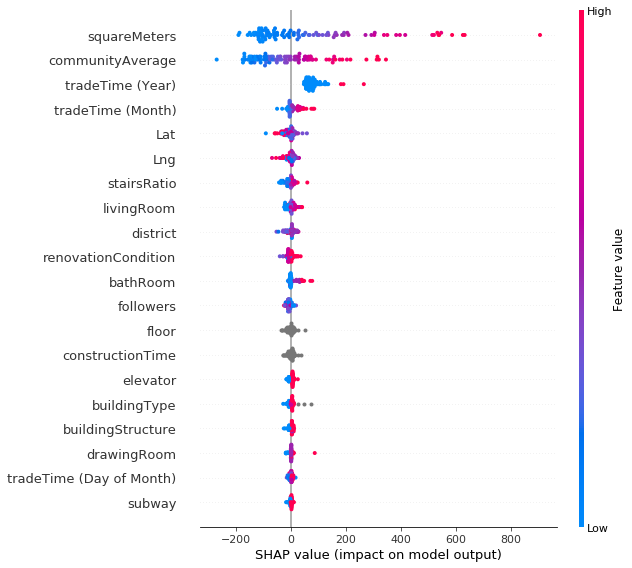

In [33]:
shap.summary_plot(shap_matrix_df.values, reordered_first_rows)

Note that the impact in this chart refers to a different set of rows than the ShapImpact we got in cell 5, so the results are slightly different. Above we had the whole validation partition; here we have the first 100 rows.

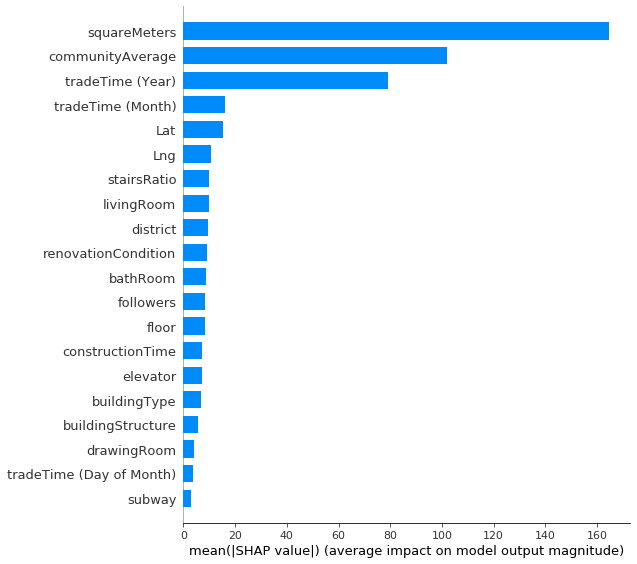

In [34]:
shap.summary_plot(shap_matrix_df.values, reordered_first_rows, plot_type='bar')

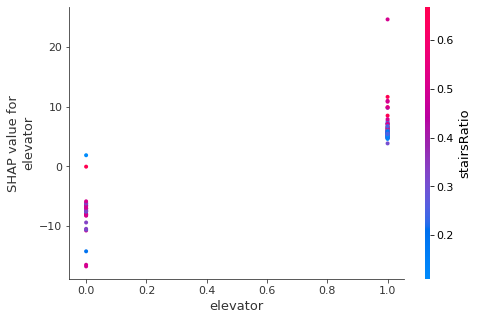

In [35]:
shap.dependence_plot('elevator', shap_matrix_df.values, reordered_first_rows, interaction_index='stairsRatio')

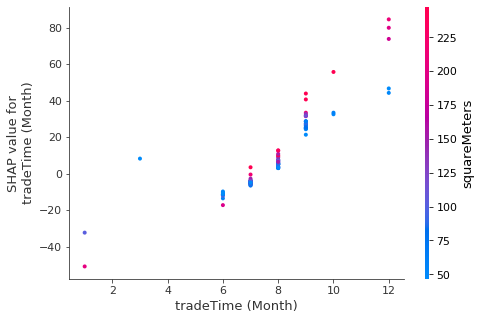

In [36]:
shap.dependence_plot('tradeTime (Month)', shap_matrix_df.values, reordered_first_rows, interaction_index='squareMeters')